Author: Émilie, emilie@bayesimpact.org

Date: 2021-06-15

# ROME update from v346 to v347

In June 2021 a new version of the ROME was released. I want to investigate what changed and whether we need to do anything about it.

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v346. You will have to trust me on the results ;-)

Skip the run test because it requires older versions of the ROME.

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas as pd

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '346'
NEW_VERSION = '347'

old_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(OLD_VERSION)))
new_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(NEW_VERSION)))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('{:d} new files'.format(len(new_files)))
print('{:d} deleted files'.format(len(deleted_files)))

0 new files
0 deleted files


Cool, no new nor deleted files.

Now let's set up a dataset that, for each table, links both the old and the new file together.

In [3]:
# Load all ROME datasets for the two versions we compare.
VersionedDataset = collections.namedtuple('VersionedDataset', ['basename', 'old', 'new'])
def read_csv(filename):
    try:
        return pd.read_csv(filename)
    except pd.errors.ParserError:
        display(f'While parsing: {filename}')
        raise

rome_data = [VersionedDataset(
        basename=path.basename(f),
        old=read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=read_csv(f))
    for f in sorted(new_version_files)]

def find_rome_dataset_by_name(data, partial_name):
    for dataset in data:
        if 'unix_{}_v{}_utf8.csv'.format(partial_name, NEW_VERSION) == dataset.basename:
            return dataset
    raise ValueError('No dataset named {}, the list is\n{}'.format(partial_name, [d.basename for d in data]))

Let's make sure the structure hasn't changed:

In [4]:
for dataset in rome_data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of {} have changed.'.format(dataset.basename))

OK no columns have changed.

Now let's see for each file if there are more or less rows.

In [5]:
same_row_count_files = 0
for dataset in rome_data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('{:d}/{:d} values added in {}'.format(
            diff, len(dataset.new.index), dataset.basename))
    elif diff < 0:
        print('{:d}/{:d} values removed in {}'.format(
            -diff, len(dataset.old.index), dataset.basename))
    else:
        same_row_count_files += 1
print('{:d}/{:d} files with the same number of rows'.format(
    same_row_count_files, len(rome_data)))

30/32321 values added in unix_coherence_item_v347_utf8.csv
6/11774 values added in unix_cr_gd_dp_appellations_v347_utf8.csv
8/13670 values added in unix_item_v347_utf8.csv
36/43971 values added in unix_liens_rome_referentiels_v347_utf8.csv
6/11118 values added in unix_referentiel_appellation_v347_utf8.csv
4/5054 values added in unix_texte_v347_utf8.csv
14/20 files with the same number of rows


There are some minor changes in many files, but based on my knowledge of ROME, none from the main files.

The most interesting ones are in `referentiel_appellation` and `liens_rome_referentiels`, so let's see more precisely.

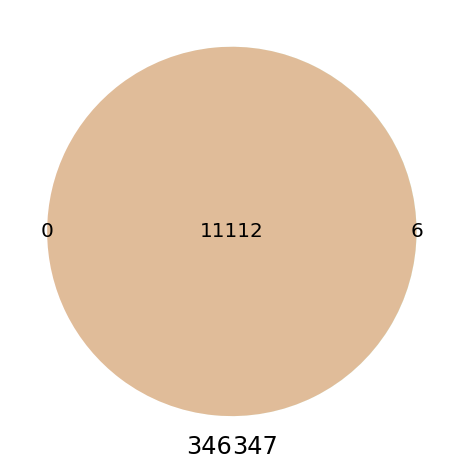

In [6]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')

new_jobs = set(jobs.new.code_ogr) - set(jobs.old.code_ogr)
obsolete_jobs = set(jobs.old.code_ogr) - set(jobs.new.code_ogr)
stable_jobs = set(jobs.new.code_ogr) & set(jobs.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_jobs), len(new_jobs), len(stable_jobs)), (OLD_VERSION, NEW_VERSION));

Alright, so the only change seems to be 6 new jobs added. Let's take a look (only showing interesting fields):

In [7]:
pd.options.display.max_colwidth = 2000
jobs.new[jobs.new.code_ogr.isin(new_jobs)][['code_ogr', 'libelle_appellation_long', 'code_rome']]

,code_ogr,libelle_appellation_long,code_rome
11112,200200,Ostéopathe animalier / animalière,A1504
11113,200201,Assistant / Assistante galeriste,D1201
11114,200202,Socio-coiffeur / Socio-coiffeuse,D1202
11115,200203,Interface de communication,K1205
11116,200204,Catalogueur / Catalogueuse,K1601
11117,200220,Destination Wedding planner,E1107


Those are indeed new jobs.

OK, let's check at the changes in items:

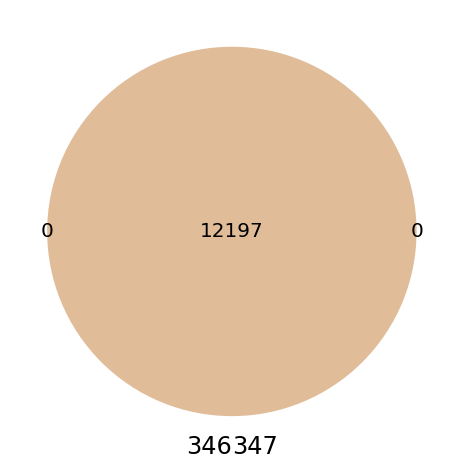

In [8]:
items = find_rome_dataset_by_name(rome_data, 'item')

new_items = set(items.new.code_ogr) - set(items.old.code_ogr)
obsolete_items = set(items.old.code_ogr) - set(items.new.code_ogr)
stable_items = set(items.new.code_ogr) & set(items.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_items), len(new_items), len(stable_items)), (OLD_VERSION, NEW_VERSION));

No changes at all, so it's merely existing items that have been newly assigned to existing groups.

The changes in `liens_rome_referentiels` might help reveal those changes:

In [9]:
links = find_rome_dataset_by_name(rome_data, 'liens_rome_referentiels')

old = links.old[['code_rome', 'code_ogr']]
new = links.new[['code_rome', 'code_ogr']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged._diff.value_counts()

added    36
Name: _diff, dtype: int64

So there are few fixes. Let's have a look at some of them:

In [10]:
job_group_names = find_rome_dataset_by_name(rome_data, 'referentiel_code_rome').new.set_index('code_rome').libelle_rome
item_names = items.new.set_index('code_ogr').libelle.drop_duplicates()
links_merged['job_group_name'] = links_merged.code_rome.map(job_group_names)
links_merged['item_name'] = links_merged.code_ogr.map(item_names)
display(links_merged[links_merged._diff == 'removed'].dropna().head(5))
links_merged[links_merged._diff == 'added'].dropna().head(10)

,code_rome,code_ogr,_merge,_diff,job_group_name,item_name


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
43936,A1504,107575,right_only,added,Santé animale,"Détecter les symptômes périphériques, les contre-indications traumatiques, inflammatoires, infectieuses et adapter la prise en charge ou orienter vers les partenaires de soins"
43937,A1504,107588,right_only,added,Santé animale,Proposer un traitement selon une orientation thérapeutique d'ostéopathie
43938,A1504,107498,right_only,added,Santé animale,Biomécanique
43939,A1504,107578,right_only,added,Santé animale,"Identification des symptomatologies (fonctionnelles, mécaniques, tissulaires, circulatoires, ...)"
43940,A1504,107580,right_only,added,Santé animale,Posturologie
43942,D1201,121611,right_only,added,"Achat vente d'objets d'art, anciens ou d'occasion","Concevoir des documents, produits documentaires (catalogue, revue de presse, ...) et les mettre à disposition des acteurs concernés"
43944,D1202,24050,right_only,added,Coiffure,Résidence de personnes âgées
43945,D1202,114147,right_only,added,Coiffure,"Dispenser des soins esthétiques à des personnes fragilisées, souffrantes ou en réinsertion sociale"
43946,D1202,102066,right_only,added,Coiffure,Techniques d'écoute et de la relation à la personne
43948,E1107,122611,right_only,added,Organisation d'évènementiel,Coordonner la logistique d'un évènement


The added items are OK.

That's all the changes we wanted to check (no change in `referentiel_code_rome`).

# Conclusion

The new version of ROME, v347, introduces very minor changes which reflect quite well what they wrote in their [changelog](http://www.pole-emploi.org/files/live/sites/peorg/files/documents/Statistiques-et-analyses/Open-data/ROME/ROME_AppropriationThematique.pdf).

We can also note that the covid-19 pandemic had an impact in this ROME update, as the "Destination wedding planner" and the "socio-coiffeur·se" have been created to be able to distinguish them. (The first ones are restructuring whereas the second ones were allowed to intervene during the crisis).


The transition should be transparent with a very small advantage over the old version.